# scNym Cell Type Classification with Cell Atlas References

This notebook trains `scNym` cell type classification models using a relevant cell atlas dataset as training data and an unlabeled dataset from new experiment as target data.

We provide cell atlases for the mouse (Tabula Muris) and rat (Rat Aging Cell Atlas).

We demonstrate scNym by training on young rat cells and predicting on old cells.
Simply change the `UPLOAD_NEW_DATA` variable in the cells below to upload your own experiment instead.

## Install dependencies and import packages

In [48]:
# allow tensorboard outputs even though TF2 is installed
# broke the tensorboard/pytorch API
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import seaborn as sns
#import scnym

import sys
sys.path.append('../../')

# import scnym
from scnym2 import scnym
from scnym2.scnym.api import scnym_api
import torch

# file downloads
import urllib
import json
import os

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [51]:
def decode_bytes_h5ad(adata):

    try:
        adata.var_names = [x.decode('utf-8') for x in adata.var_names]
        adata.obs.index = [x.decode('utf-8') for x in adata.obs.index]
    except:
        pass

    ## Everything gets read in as bytes, so we decode each column in the dataframe here
    for c in adata.obs.columns:
        try:
            adata.obs[c] = [x.decode('utf-8') for x in adata.obs[c]]
        except:
            continue
    return adata

## Train an scNym model

Here, we train an scNym model using the MixMatch semi-supervised learning method to transfer lables from the training data set to the target data set.

## Prepare data for training

The scNym API expects a single `anndata.AnnData` object with a column in `AnnData.obs` defining the annotations to learn.
Cells annotated with the special token `"Unlabeled"` will be treated as part of the target dataset.
These cells will be used for semi-supervised and adversarial training.

In [52]:
# Class-specific data augmentation
def augment_class(adata, class_, col='cell', 
                  augment_type='dropout', drop_ratio=0.25, augment_size=4000):
    subset = adata[adata.obs[col]== class_]
    subset_data = subset.X.toarray()
    idx = np.random.choice(range(subset_data.shape[0]),augment_size)
    if augment_type == 'dropout':
        Z = np.array([dropout_vec(v, drop_ratio) for v in subset_data[idx]])
    
    Z = sc.AnnData(Z)
    Z.var_names = adata.var_names
    Z.obs['augmented'] = True
    for c in adata.obs.columns:
        Z.obs[c] = subset.obs[c].values[0]
    return sc.concat([adata, Z], join='outer')

def dropout_vec(vec, drop_ratio=0.1):
    non_zero = np.where(vec!=0)[0]
    nz_idx = np.random.choice(non_zero, int(len(non_zero)*drop_ratio), replace=False)
    new_vec = np.array(vec)
    new_vec[nz_idx] = 0
    return new_vec

In [53]:
adata = sc.read_h5ad('/dfs/project/CS329D/data/kang_2017_stim_pbmc.h5ad')
adata = decode_bytes_h5ad(adata)

In [54]:
name = 'model3_nolossweight_inclOther'
map_dict = {'CD4 T cells':'T cells', 
            'CD14+ Monocytes':'Monocytes', 
            'Dendritic cells':'Other', 
            'NK cells':'Other',
            'CD8 T cells':'T cells', 
            'B cells':'Other', 
            'Megakaryocytes': 'Other', 
            'FCGR3A+ Monocytes': 'Monocytes'}

In [55]:
adata = sc.read_h5ad('/dfs/project/CS329D/data/kang_2017_stim_pbmc.h5ad')
adata = decode_bytes_h5ad(adata)

adata.obs['coarse_y'] = adata.obs['cell'].map(map_dict)

augment = []
#augment = ['FCGR3A+ Monocytes']

train_adata = adata[adata.obs['stim'] == 'ctrl']
target_adata = adata[adata.obs['stim'] == 'stim']

for c in augment:
    train_adata = augment_class(train_adata, c)
    target_adata = augment_class(target_adata, c)

train_adata.obs['annotations'] = np.array(
    train_adata.obs['cell']
)
target_adata.obs['annotations'] = 'Unlabeled'

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [9]:
"""
# NOTE: Here we downsample the atlas to avoid memory issues
# with free Colab VMs
MAX_N_CELLS = 20000
if train_adata.shape[0] > MAX_N_CELLS:
  print('Downsampling training data to fit in memory.')
  print('Note: Remove this step if you have high RAM VMs through Colab Pro.')
  ridx = np.random.choice(train_adata.shape[0], size=MAX_N_CELLS, replace=False)
  train_adata = train_adata[ridx, :]
"""

"\n# NOTE: Here we downsample the atlas to avoid memory issues\n# with free Colab VMs\nMAX_N_CELLS = 20000\nif train_adata.shape[0] > MAX_N_CELLS:\n  print('Downsampling training data to fit in memory.')\n  print('Note: Remove this step if you have high RAM VMs through Colab Pro.')\n  ridx = np.random.choice(train_adata.shape[0], size=MAX_N_CELLS, replace=False)\n  train_adata = train_adata[ridx, :]\n"

In [56]:
adata = train_adata.concatenate(target_adata)

print('%d cells, %d genes in the joined training and target set.' % adata.shape)

29056 cells, 35635 genes in the joined training and target set.


In [57]:
# save genes used in the model
np.savetxt('./model_genes.csv', train_adata.var_names, fmt='%s')
model_genes = np.loadtxt('./model_genes.csv', dtype='str')

### Train the scNym model

**NOTE:** Training is computationally expensive and many take 1+ hours using the free Colab GPU.
If you'd like to train more models more quickly, consider [connecting Colab to a local runtime with a GPU](https://research.google.com/colaboratory/local-runtimes.html), using [Colab Pro](https://colab.research.google.com/signup?utm_source=faq&utm_medium=link&utm_campaign=why_arent_resources_guaranteed), or downloading this notebook as a Python script and running it on a GPU equipped machine (e.g. in a cluster at your institution).

scNym saves a copy of the best weights determined using early stopping on the validation criterion in `{out_path}/00_best_model_weights.pkl`.
We load the best weights after training is finished to use for prediction on the target dataset.

In [14]:
name = 'sc_1'

In [ ]:
scnym_api(
    adata=adata,
    full_adata = adata,
    task='train',
    groupby='annotations',
    out_path='./scnym_outputs/' + name,
    config='no_ssl',
)

## Predict cell types in target data

After training the model, we load the best set of weights selected using early stopping and predict cell types for the target data set.

In [18]:
#subset_adata = adata[adata.obs['augmented'] != True]

scnym_api(
    adata=target_adata,
    full_adata = adata,
    task='predict',
    key_added='scNym',
    config='no_new_identity',
    trained_model='../scnym_outputs/sc_1/' 
)

CUDA compute device found.


TypeError: new() received an invalid combination of arguments - got (NoneType, int), but expected one of:
 * (torch.device device)
 * (torch.Storage storage)
 * (Tensor other)
 * (tuple of ints size, torch.device device)
      didn't match because some of the arguments have invalid types: ([31;1mNoneType[0m, [31;1mint[0m)
 * (object data, torch.device device)
      didn't match because some of the arguments have invalid types: ([31;1mNoneType[0m, [31;1mint[0m)


In [ ]:
target_adata.write_h5ad('results_map_dict_'+name+'.h5ad')
np.save('map_dict_'+name+'.npy',map_dict)

In [43]:
target_adata = sc.read_h5ad('../training_sets/results_map_dict_raw_05-31_21-11-11.h5ad')
target_adata = decode_bytes_h5ad(target_adata)

### Measuring performance


In [ ]:
preds = pd.DataFrame(target_adata.obs['cell'][target_adata.obs['scNym'].values != target_adata.obs['cell'].values].value_counts())

In [45]:
df = target_adata[target_adata.obs['scNym'].values != target_adata.obs['cell'].values].obs
df[df['cell'] == 'Megakaryocytes']['scNym'].value_counts()

CD4 T cells          38
B cells              18
CD14+ Monocytes      10
NK cells              2
Dendritic cells       1
FCGR3A+ Monocytes     1
CD8 T cells           1
Name: scNym, dtype: int64

In [46]:
before_df = pd.DataFrame.from_dict({
    'FCGR3A+ Monocytes':313,
    'CD8 T cells':281,
    'NK cells':187,
    'CD4 T cells':139,
    'CD14+ Monocytes':89,
    'Megakaryocytes':87,
    'Dendritic cells':56,
    'B cells':29
    },orient='index', columns=['before'])

In [47]:
new_df = preds.reset_index().merge(before_df.reset_index(), on='index', how='outer')
new_df = new_df.fillna(0)
new_df = new_df.rename(columns={'cell':'after'})
#new_df = new_df.set_index('index')
plot_df = new_df.melt(id_vars= 'index')
plot_df = plot_df.sort_values('variable', ascending=False)

counts = pd.DataFrame(train_adata.obs['cell'].value_counts())
counts = counts.rename(columns={'cell':'count'})
plot_df = plot_df.merge(counts.reset_index(), on='index', how='outer')
plot_df['value_percent'] = plot_df['value']/plot_df['count']

Text(0.5, 6.79999999999999, 'Cell type')

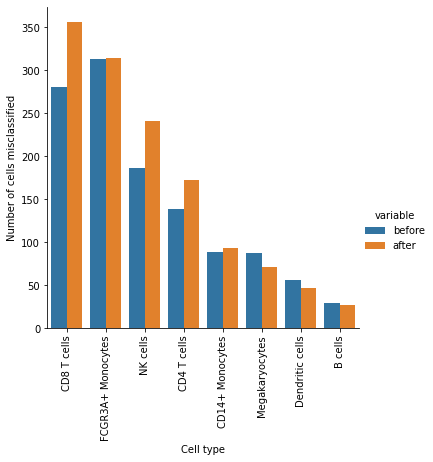

In [48]:
sns.catplot(data=plot_df, x='index', y='value', hue="variable", kind="bar")
ax = plt.gca()
plt.xticks(rotation=90)
plt.ylabel('Number of cells misclassified')
plt.xlabel('Cell type')

Text(0.5, 6.79999999999999, 'Cell type')

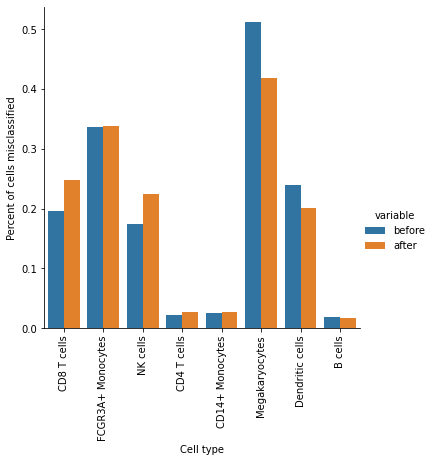

In [49]:
sns.catplot(data=plot_df, x='index', y='value_percent', hue="variable", kind="bar")
ax = plt.gca()
plt.xticks(rotation=90)
plt.ylabel('Percent of cells misclassified')
plt.xlabel('Cell type')

In [58]:
# With data augmentation
def get_acc(adata):
    return np.sum(np.array(adata.obs['scNym'].values) == np.array(adata.obs['cell'].values))/\
                len(adata)

def get_macro_acc(adata):
    matrix = confusion_matrix(y_true=np.array(adata.obs[true_key].values), 
                              y_pred=np.array(adata.obs[key].values))
    accuracy = matrix.diagonal() / matrix.sum(axis=1)
    accuracy = accuracy.mean()
    return accuracy

from sklearn.metrics import confusion_matrix
true_key = 'cell'
key = 'scNym'
data = res_adata

def get_macro_acc(data):
    matrix = confusion_matrix(y_true=np.array(data.obs[true_key].values), 
                              y_pred=np.array(data.obs[key].values))
    accuracy = matrix.diagonal() / matrix.sum(axis=1)
    accuracy = accuracy.mean()
    return accuracy

### Read in target adata for all experiments

In [85]:
pd.read_csv('../training_sets/description_df.csv').loc[1,'decsription']

'Partial coarse level annotation available for test and train, discard all else'

In [33]:
import glob

results = {}
macro_results = {}

for f in glob.glob('../training_sets/results_map_dict_*.h5ad'):
    print(f)
    try:
        res_adata = decode_bytes_h5ad(sc.read_h5ad(f))
        results[f] = get_acc(res_adata)
        macro_results[f] = get_macro_acc(res_adata)
    except:
        continue

../training_sets/results_map_dict_sc_4_06-02_23-00-40.h5ad
../training_sets/results_map_dict_rat_sc_1_06-03_10-46-25.h5ad
../training_sets/results_map_dict_sc_1_06-03_11-48-59.h5ad
../training_sets/results_map_dict_sc_4_06-02_23-49-43.h5ad
../training_sets/results_map_dict_sc_1_05-31_22-36-03.h5ad
../training_sets/results_map_dict_sc_1_06-03_11-36-25.h5ad
../training_sets/results_map_dict_sc_4_06-02_23-25-28.h5ad
../training_sets/results_map_dict_sc_1_05-31_22-09-51.h5ad
../training_sets/results_map_dict_sc_4_06-02_21-58-01.h5ad
../training_sets/results_map_dict_sc_3_06-02_22-32-56.h5ad
../training_sets/results_map_dict_rat_sc_1_06-03_12-12-33.h5ad
../training_sets/results_map_dict_sc_1_06-03_11-11-21.h5ad
../training_sets/results_map_dict_sc_1_06-01_00-00-10.h5ad
../training_sets/results_map_dict_raw_05-31_22-06-41.h5ad
../training_sets/results_map_dict_raw_05-31_22-52-52.h5ad
../training_sets/results_map_dict_raw_05-31_22-29-06.h5ad
../training_sets/results_map_dict_raw_05-31_23-12-0

In [34]:
results

{'../training_sets/results_map_dict_sc_4_06-02_23-00-40.h5ad': 0.9260229364292794,
 '../training_sets/results_map_dict_rat_sc_1_06-03_10-46-25.h5ad': 0.9587525288736864,
 '../training_sets/results_map_dict_sc_1_06-03_11-48-59.h5ad': 0.941880220869319,
 '../training_sets/results_map_dict_sc_4_06-02_23-49-43.h5ad': 0.9268724338099957,
 '../training_sets/results_map_dict_sc_1_05-31_22-36-03.h5ad': 0.9490301571570154,
 '../training_sets/results_map_dict_sc_1_06-03_11-36-25.h5ad': 0.9456321676341498,
 '../training_sets/results_map_dict_sc_4_06-02_23-25-28.h5ad': 0.9099532776440606,
 '../training_sets/results_map_dict_sc_1_05-31_22-09-51.h5ad': 0.9486761999150503,
 '../training_sets/results_map_dict_sc_4_06-02_21-58-01.h5ad': 0.9037944216338666,
 '../training_sets/results_map_dict_sc_3_06-02_22-32-56.h5ad': 0.9201472462126575,
 '../training_sets/results_map_dict_rat_sc_1_06-03_12-12-33.h5ad': 0.9583141146544519,
 '../training_sets/results_map_dict_sc_1_06-03_11-11-21.h5ad': 0.947826702534333

In [42]:
keep_k = [k for k in results.keys() if 'rat' in k and 'sc_2' in k]

In [46]:
np.mean([macro_results[k] for k in keep_k])*100

85.21884449239812

In [147]:
fname1 = ('../training_sets/results_map_dict_sc_1_06-01_00-00-10.h5ad')
fname2 = ('../training_sets/results_map_dict_raw_05-31_21-11-11.h5ad')

In [150]:
adata = decode_bytes_h5ad(sc.read_h5ad(fname2))

true_key = 'cell'
key = 'scNym'
data = res_adata

y_true=np.array(adata.obs[true_key].values)

In [151]:
matrix2 = confusion_matrix(y_true=np.array(adata.obs[true_key].values), 
                          y_pred=np.array(adata.obs[key].values))

In [158]:
np.fill_diagonal(matrix1, -1)
np.fill_diagonal(matrix2, -1)

In [155]:
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
%matplotlib inline

In [161]:
df1 = pd.DataFrame(matrix1, columns = np.unique(y_true), 
                         index=np.unique(y_true))

df2 = pd.DataFrame(matrix2, columns = np.unique(y_true), 
                         index=np.unique(y_true))

df1 = df1.replace(-1,np.NaN)
df2 = df2.replace(-1,np.NaN)

In [170]:
df2

,B cells,CD14+ Monocytes,CD4 T cells,CD8 T cells,Dendritic cells,FCGR3A+ Monocytes,Megakaryocytes,NK cells
B cells,NaN,0.0,13.0,0.0,5.0,0.0,8.0,1.0
CD14+ Monocytes,5.0,NaN,19.0,0.0,27.0,21.0,21.0,0.0
CD4 T cells,95.0,16.0,NaN,46.0,0.0,0.0,13.0,2.0
CD8 T cells,21.0,0.0,270.0,NaN,0.0,1.0,2.0,62.0
Dendritic cells,31.0,10.0,3.0,0.0,NaN,0.0,2.0,1.0
FCGR3A+ Monocytes,30.0,224.0,19.0,0.0,33.0,NaN,6.0,2.0
Megakaryocytes,18.0,10.0,38.0,1.0,1.0,1.0,NaN,2.0
NK cells,14.0,16.0,72.0,131.0,2.0,1.0,5.0,NaN


In [169]:
df1

,B cells,CD14+ Monocytes,CD4 T cells,CD8 T cells,Dendritic cells,FCGR3A+ Monocytes,Megakaryocytes,NK cells
B cells,NaN,1.0,1.0,0.0,6.0,0.0,7.0,4.0
CD14+ Monocytes,0.0,NaN,1.0,0.0,0.0,33.0,5.0,0.0
CD4 T cells,0.0,6.0,NaN,34.0,0.0,0.0,5.0,0.0
CD8 T cells,0.0,0.0,291.0,NaN,0.0,0.0,2.0,0.0
Dendritic cells,36.0,1.0,0.0,0.0,NaN,0.0,4.0,2.0
FCGR3A+ Monocytes,8.0,262.0,2.0,0.0,0.0,NaN,1.0,0.0
Megakaryocytes,19.0,1.0,3.0,0.0,0.0,0.0,NaN,6.0
NK cells,8.0,0.0,1.0,0.0,3.0,0.0,7.0,NaN


Text(0.5, 51.0, 'Predicted label')

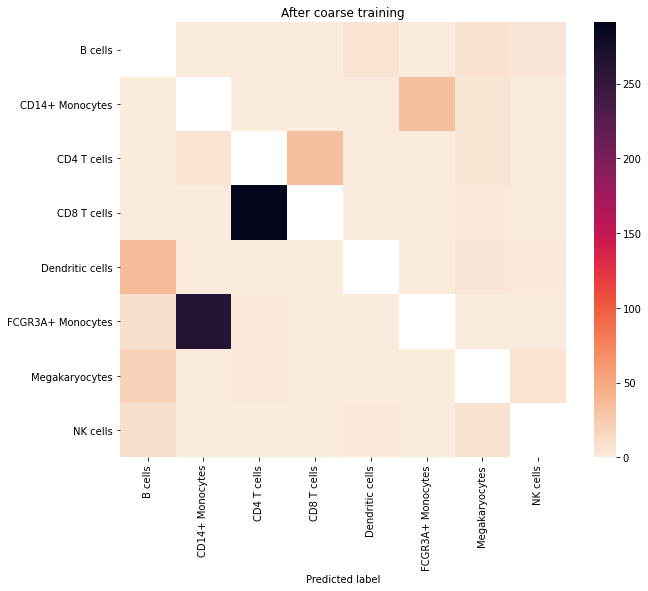

In [171]:
plt.figure(figsize=[10,8])
sns.heatmap(df1, cmap='rocket_r')
plt.title('After coarse training')
plt.xlabel('Predicted label')

Text(0.5, 51.0, 'Predicted label')

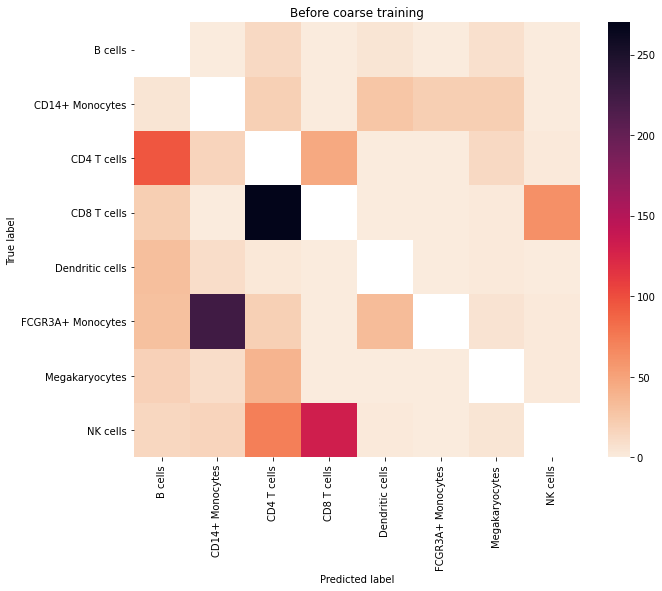

In [172]:
plt.figure(figsize=[10,8])
sns.heatmap(df2, cmap='rocket_r')
plt.title('Before coarse training')
plt.ylabel('True label')
plt.xlabel('Predicted label')

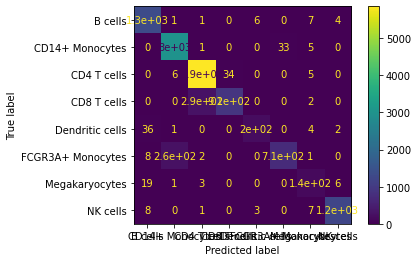

In [82]:
disp = ConfusionMatrixDisplay(matrix, np.unique(y_true))
disp.plot()

In [60]:
out1 = sc.read_h5ad(fname1)
out2 = sc.read_h5ad(fname2)

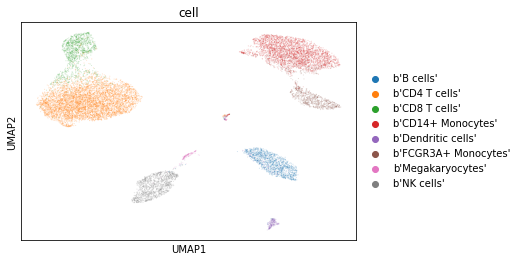

In [77]:
sc.pp.neighbors(out1, use_rep='X_scnym', n_neighbors=30)
sc.tl.umap(out1, min_dist=0.3)
sc.pl.umap(out1, color='cell', size=5., alpha=0.2)

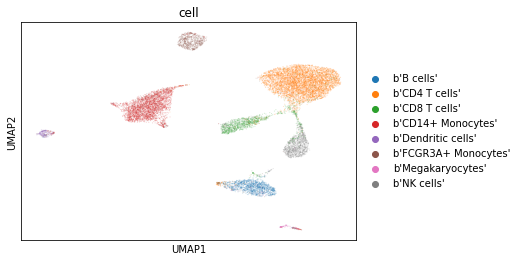

In [78]:
#sc.pp.neighbors(out2, use_rep='X_scnym', n_neighbors=30)
#sc.tl.umap(out2, min_dist=0.3)
sc.pl.umap(out2, color='cell', size=5., alpha=0.2)

In [77]:
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy'])
results_df['model'] = [r.split('dict_')[-1].split('_0')[0].split('.h5ad')[0] for r in results_df.index]

(0.88, 0.96)

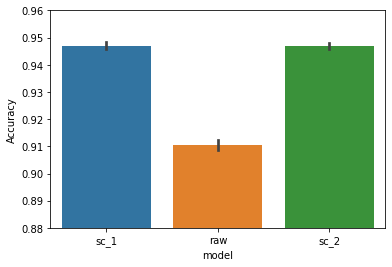

In [80]:
sns.barplot(data=results_df, y='Accuracy', x='model')
plt.ylim([0.88,0.96])

## Plot cell type predictions

In [87]:
def match_colors(
    adata: anndata.AnnData,
    source_cat: str,
    target_cat: str,
    extend_pal=sns.color_palette('tab20'),
) -> anndata.AnnData:
    '''Match the colors used for common categories across categorical
    variables in a an AnnData object.
    
    Parameters
    ----------
    adata : anndata.AnnData
        [Cells, Genes] with `source_cat` and `target_cat` in `.obs`
        if source colors not present in `.uns[f"{source_cat}_colors"]`,
        they will be added using `extend_pal`.
    source_cat : str
        source categorical with a set of colors to copy.
    target_cat : str
        target categorical that will adopt colors from `source_cat`.
        
    Returns
    -------
    adata : anndata.AnnData
        [Cells, Genes]
    '''
    adata.obs[source_cat] = pd.Categorical(adata.obs[source_cat].tolist())
    if f'{source_cat}_colors' not in adata.uns.keys():
        sc.pl._utils.add_colors_for_categorical_sample_annotation(
            adata,
            source_cat,
            palette=extend_pal,
        )
    
    # define an rgb to hex mapping
    rgb2hex = lambda r,g,b: f'#{r:02x}{g:02x}{b:02x}'
    
    source_colors = adata.uns[f'{source_cat}_colors']
    source_levels = pd.Categorical(adata.obs[source_cat]).categories
    
    source_colors = {
        source_levels[i]: source_colors[i] for i in range(len(source_colors))
    }

    target_levels = pd.Categorical(adata.obs[target_cat]).categories
    target_colors = []
    
    i = 0 # how many keys have we added from the source colors?
    j = 0 # how many colors have we used from the extending palette?
    for target_lev in target_levels:
        if target_lev in source_colors.keys():
            target_colors.append(source_colors[target_lev])
            i += 1
        else:
            idx2get = len(source_colors)+j+1
            target_colors.append(
                rgb2hex(*(np.array(extend_pal[idx2get%len(extend_pal)])*255).astype(np.int))
            )
            j += 1
    adata.uns[f'{target_cat}_colors'] = target_colors
    
    return adata

In [90]:
target_adata = match_colors(
    adata=target_adata,
    source_cat='cell_ontology_class',
    target_cat='scNym',
)

/dfs/project/CS329D/sc/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'GSM' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'age' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_ontology_class' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type_short' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sex' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'tissue' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'annotations' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'scNym' as categorical


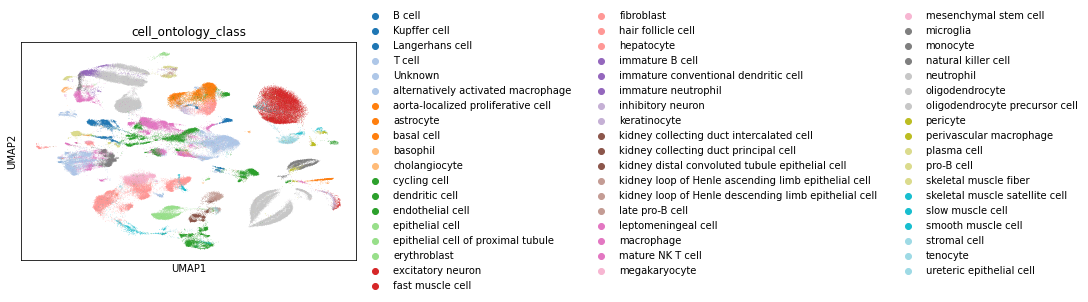

In [89]:
# True labels

sc.pl.umap(
    target_adata,
    color='cell_ontology_class',
    palette='tab20',
)

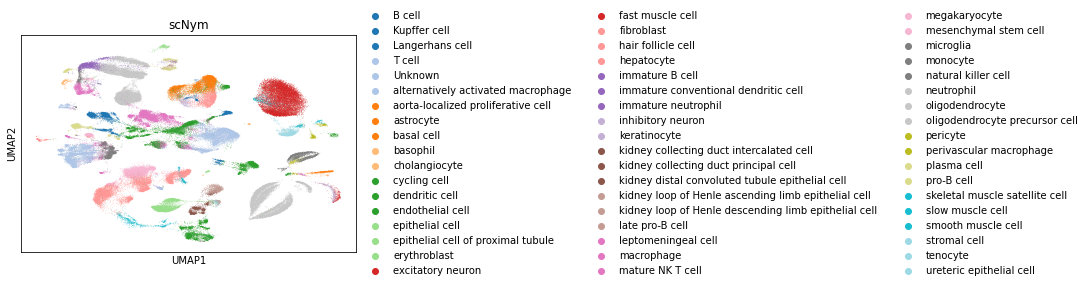

In [91]:
# Predictions

sc.pl.umap(
    target_adata,
    color='scNym',
)

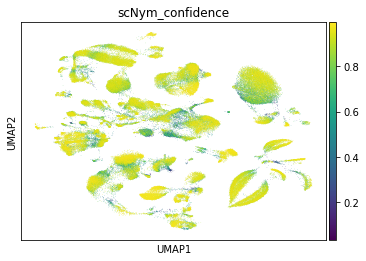

In [92]:
sc.pl.umap(
  target_adata,
  color='scNym_confidence',
)

## Plot model embeddings

`scnym_api` also extracts the activations of the penultimate neural network layer. These activations represent the embedding learned by the scNym model.

In [27]:
sc.pp.neighbors(target_adata, use_rep='X_scnym', n_neighbors=30)

/dfs/project/CS329D/sc/lib/python3.7/site-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../project/CS329D/sc/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/dfs/project/CS329D/sc/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../project/CS329D/sc/lib/python3.7/si

KeyboardInterrupt: 

In [ ]:
sc.tl.umap(adata, min_dist=0.3)

... storing 'GSM' as categorical
... storing 'age' as categorical
... storing 'cell_ontology_class' as categorical
... storing 'cell_type' as categorical
... storing 'cell_type_short' as categorical
... storing 'sex' as categorical
... storing 'tissue' as categorical
... storing 'annotations' as categorical
... storing 'scNym' as categorical


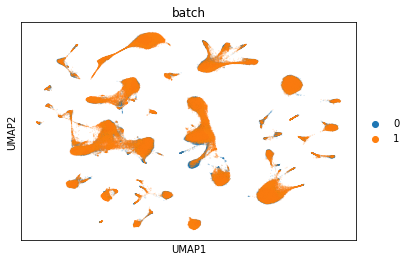

In [95]:
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(adata, color='batch', size=5., alpha=0.2)

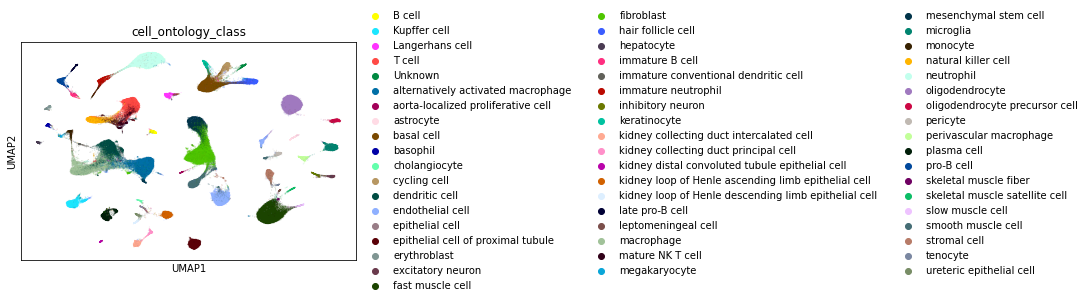

In [96]:
sc.pl.umap(adata, color='cell_ontology_class', size=5., alpha=0.2)

## Save scNym annotations to locally or to gDrive

In [97]:
target_adata.obs.to_csv(
    './annotations.csv'
)

In [ ]:
# save files locally
from google.colab import files

files.download('annotations.csv')

In [ ]:
# save files to Google Drive
from google.colab import drive
drive.mount('/gdrive')

# make a directory if not present already
!mkdir "/gdrive/My Drive/scnym/"
# copy file to gDrive
!cp annotations.csv "/gdrive/My Drive/scnym/annotations.csv"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
mkdir: cannot create directory ‘/gdrive/My\\ Drive/scnym/’: No such file or directory
cp: cannot create regular file '/gdrive/My\ Drive/scnym/annotations.csv': No such file or directory


/dfs/project/CS329D/sc/lib/python3.7/site-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../project/CS329D/sc/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
... storing 'cell' as categorical
... storing 'multiplets' as categorical
... storing 'stim' as categorical
... storing 'annotations' as categorical
... storing 'scNym' as categorical


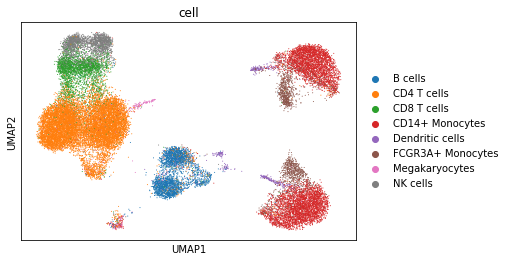

In [49]:
# Visualizing single-cell expession data



sc.pp.neighbors(adata)
sc.tl.pca(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='cell')

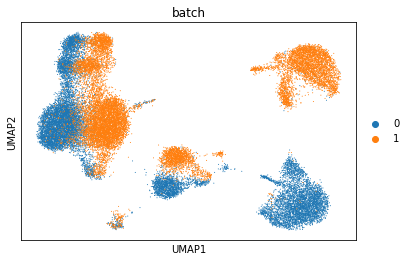

In [52]:
sc.pl.umap(adata, color=['batch'])